In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import l1_min_c

# 50. Download and Preprocess Dataset

Use *Knime* Workflow to read the CSV file and preprocess the datasets
The created Workflow can be found in the directory **src/chapter06_knime_workflow**

1. Number of instances in train.txt = 7750
2. Number of instances in valid.txt = 944
3. Number of instances in test.txt  = 944
4.                            TOTAL = 9438

# 51. Feature extraction

In [4]:
_TRAIN = "train"
_VALID = "valid"
_TEST = "test"

def _get_file_path(name: str = _TRAIN) -> str:
    return "text/" + name + ".txt"

In [5]:
def _find_all_tokens(FILE_PATH: str) -> list:
    dataset = pd.read_csv(FILE_PATH, sep = "\t")
    df = pd.DataFrame(dataset)
    texts = list(df["TITLE"])
    vec = CountVectorizer(binary=False, max_features=1000)
    vec.fit(texts)
    return vec

def _compute_vectors(FILE_PATH: str, vec: object) -> object:
    df = pd.DataFrame(pd.read_csv(FILE_PATH, sep = "\t"))
    count_vectors = pd.DataFrame(vec.transform(list(df["TITLE"])).toarray(), columns=sorted(vec.vocabulary_.keys()))
    return count_vectors

def _write_features_file(IN_FILE_PATH: str, OUT_FILE_PATH: str, vectors: object) -> None:
    dataset = pd.read_csv(IN_FILE_PATH, sep = "\t")
    df = pd.DataFrame(dataset)
    df = df[["CATEGORY"]]
    vectors = vectors.assign(col_name=df)
    vectors.to_csv(OUT_FILE_PATH)

def _compute_features(FILE_NAME: str, vec: object) -> None:
    _INPUT_FILE = _get_file_path(FILE_NAME)
    vectors = _compute_vectors(_INPUT_FILE, vec)
    _OUTPUT_FILE = _get_file_path("".join([FILE_NAME, ".feature"]))
    _write_features_file(_INPUT_FILE, _OUTPUT_FILE, vectors)

In [6]:
vec = _find_all_tokens(_get_file_path())
_compute_features(_TRAIN, vec)
_compute_features(_VALID, vec)
_compute_features(_TEST, vec)

# 52. Training

In [7]:
def _get_regression_axis(FILE_NAME: str) -> object:
    dataset = pd.read_csv(_get_file_path(FILE_NAME))
    df = pd.DataFrame(dataset)
    x = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return x, y

x_train, y_train = _get_regression_axis("train.feature")
x_test, y_test = _get_regression_axis("test.feature")
x_valid, y_valid = _get_regression_axis("valid.feature")

model = LogisticRegression(solver="liblinear").fit(x_train, y_train)

# 53. Prediction

In [8]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_valid_pred = model.predict(x_valid)

y_test_pred

array(['b', 'e', 'b', 'e', 'e', 'm', 'b', 'b', 'e', 'e', 'e', 't', 'e',
       'b', 'e', 'b', 'b', 'e', 'e', 'b', 'b', 'e', 'e', 'e', 't', 'b',
       'e', 'e', 'e', 'e', 'e', 'b', 'e', 'e', 'b', 't', 'e', 'b', 'e',
       'e', 't', 'e', 't', 'b', 'b', 'b', 'e', 'e', 'e', 'b', 'e', 'e',
       'e', 'e', 'e', 't', 'b', 'e', 'e', 'e', 'm', 'b', 'b', 't', 'b',
       'e', 'e', 'e', 'b', 'e', 'e', 'e', 'b', 'e', 'e', 'e', 't', 'e',
       'e', 'b', 'e', 't', 'e', 'b', 'e', 'e', 'e', 'b', 'e', 'e', 'e',
       'b', 'e', 'e', 'e', 'e', 'e', 'b', 'e', 'e', 'b', 'e', 'e', 'e',
       'e', 'b', 'b', 'e', 'e', 'm', 'e', 'e', 'e', 'e', 'b', 'e', 'e',
       'e', 'e', 'b', 'e', 'e', 'e', 'e', 'b', 'e', 'e', 'b', 'b', 't',
       'e', 'e', 'e', 'b', 't', 'e', 'b', 'e', 'e', 'e', 'e', 'e', 'e',
       'e', 'e', 'e', 'e', 'b', 'b', 'e', 'b', 't', 'e', 't', 'e', 'e',
       'm', 't', 'e', 'e', 'e', 'b', 'b', 'e', 't', 'e', 'b', 'e', 'e',
       'e', 'e', 'b', 'e', 'b', 'e', 'b', 'm', 'e', 'b', 'e', 'e

# 54. Accuracy score

In [9]:
print("Accuracy for the Training Data:", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy for the Test Data:", metrics.accuracy_score(y_test, y_test_pred))

Accuracy for the Training Data: 0.8617218543046358
Accuracy for the Test Data: 0.823093220338983


# 55. Confusion matrix

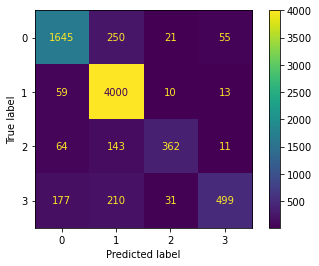

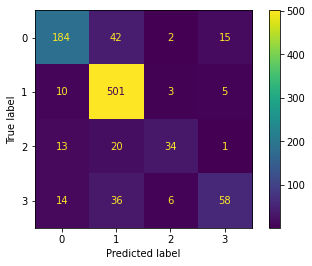

In [10]:
#Confusion Matrix for the Training Data:
disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_train, y_train_pred))
disp.plot()

#Confusion Matrix for the Test Data:
disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test, y_test_pred))
disp.plot()
plt.show()

# 56. Precision, recall and F1 score

In [11]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           b       0.83      0.76      0.79       243
           e       0.84      0.97      0.90       519
           m       0.76      0.50      0.60        68
           t       0.73      0.51      0.60       114

    accuracy                           0.82       944
   macro avg       0.79      0.68      0.72       944
weighted avg       0.82      0.82      0.81       944



# 57. Feature weights

In [12]:
def _display_result(weights: list, label: str, order: tuple) -> None:
    print(f"{order[0]} important features of {label}:")
    for index in range(order[1], order[2]):
        print(f"\t{weights[index][0]} : {weights[index][1]}")

def _get_weight(feature: tuple) -> int:
    return feature[1]

for index in range(0, len(model.classes_)):
    weights = tuple(zip(model.feature_names_in_, model.coef_[index]))  
    weights_sorted_by_coef = sorted(weights, key=_get_weight)
    weight_len = len(weights)
    label = model.classes_[index]
    _display_result(weights_sorted_by_coef, label, ["Least", 0, 10])
    _display_result(weights_sorted_by_coef, label, ["Most", weight_len-10, weight_len])
    print()

Least important features of b:
	her : -1.3524642111439447
	she : -1.329499487414091
	kardashian : -1.1992392356031512
	and : -1.0565899362572515
	star : -1.05639768874379
	kim : -0.9102428822079327
	chris : -0.8727192510969038
	cyrus : -0.8397261355748462
	video : -0.8372400868731532
	miley : -0.834107757650878
Most important features of b:
	ceo : 0.9851714582159117
	euro : 1.0470855621814352
	yellen : 1.0668001043506818
	ecb : 1.103389386881858
	profit : 1.1087842349354957
	stocks : 1.2195669150608088
	bank : 1.3905697348382762
	fed : 1.4484738547043763
	billion : 1.4961237029978314
	china : 1.5427210578168298

Least important features of e:
	google : -2.762634863376461
	facebook : -2.4024612310886497
	bank : -2.2478903264175947
	billion : -2.1587064621804837
	obamacare : -2.1147782494396083
	ebola : -2.0935451350862904
	climate : -1.9516927229138124
	china : -1.92888201336349
	microsoft : -1.924568243079531
	study : -1.9218864346879847
Most important features of e:
	trailer : 1.88222

# 58. Regularization

In [13]:
_CS = l1_min_c(x_train, y_train, loss="log") * np.logspace(0, 7, 16)
_model = LogisticRegression(solver="liblinear")

_train_coef = []
_test_coef = []
_valid_coef = []

for _C in _CS:
    _model.set_params(C=_C)
    _model.fit(x_train, y_train)
                       
    y_train_pred = _model.predict(x_train)
    y_test_pred = _model.predict(x_test)
    y_valid_pred = _model.predict(x_valid)
    
    _train_coef.append(metrics.accuracy_score(y_train, y_train_pred))
    _test_coef.append(metrics.accuracy_score(y_test, y_test_pred))
    _valid_coef.append(metrics.accuracy_score(y_valid, y_valid_pred))

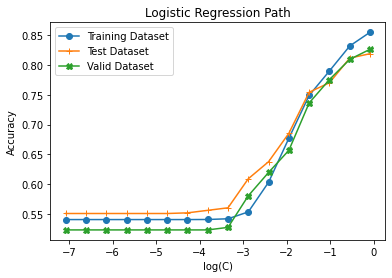

In [14]:
_train_coef = np.array(_train_coef)
_test_coef = np.array(_test_coef)
_valid_coef = np.array(_valid_coef)

plt.plot(np.log10(_CS), _train_coef, marker="o", label="Training Dataset")
plt.plot(np.log10(_CS), _test_coef, marker="+", label="Test Dataset")
plt.plot(np.log10(_CS),_valid_coef, marker="X", label="Valid Dataset")
plt.xlabel("log(C)")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.legend()
plt.show()

# 59. Hyper-parameter tuning

In [30]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


classifiers = [
    ("Logistic", LogisticRegression(solver="liblinear")),
    ("SVM", svm.SVC()),
    ("ASGD", SGDClassifier(average=True)),
    ("Random Forest", RandomForestClassifier()),
    ("Naive Bayes", GaussianNB())
]

names = []
accuracy = []

for name, model in classifiers:
    names.append(name)
    model.fit(x_train, y_train)
    y_valid_pred = model.predict(x_valid)
    accuracy.append(metrics.accuracy_score(y_valid, y_valid_pred))
    
print(accuracy)

[0.8315677966101694, 0.5233050847457628, 0.524364406779661, 0.8125, 0.6641949152542372]


In [31]:
classifiers = [
    ("Logistic", LogisticRegression(solver="liblinear", C=1)),
    ("Logistic", LogisticRegression(solver="liblinear", C=10)),
    ("Logistic", LogisticRegression(solver="liblinear", C=100)),
    ("Logistic", LogisticRegression(solver="liblinear", C=500)),
    ("Logistic", LogisticRegression(solver="liblinear", C=1000)),
    ("Logistic", LogisticRegression(solver="liblinear", C=1500)),
    ("Logistic", LogisticRegression(solver="liblinear", C=2000)),
]

names = []
accuracy = []

for name, model in classifiers:
    names.append(name)
    model.fit(x_train, y_train)
    y_valid_pred = model.predict(x_valid)
    accuracy.append(metrics.accuracy_score(y_valid, y_valid_pred))
    
print(accuracy)

[0.8315677966101694, 0.8379237288135594, 0.8389830508474576, 0.8389830508474576, 0.8442796610169492, 0.8389830508474576, 0.8389830508474576]


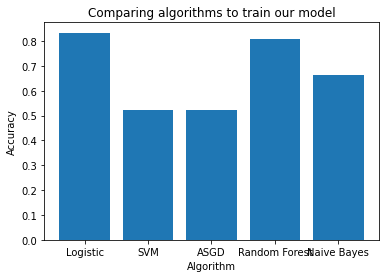

In [24]:
plt.bar(names, accuracy)
plt.title("Comparing algorithms to train our model")
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.show()